In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met, u_darrays as uda
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
shearfac = 0.71 # monthly: 0.55 mm / unit shear
tcwvfac = 3.12 # % 0.39%    3.1 % / unit tcw
tcabsfac = 1.22 # spread 0.1    1.2 mm / unit tcw

mmPerPercent = tcabsfac/tcwvfac

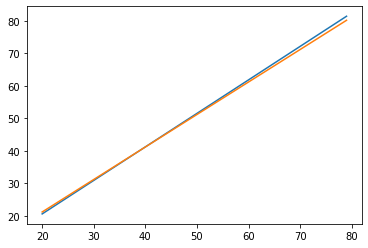

In [4]:
plt.plot(np.arange(20,80), np.arange(20,80)+np.arange(20,80)*0.0312)
plt.plot(np.arange(20,80), np.arange(20,80)+1.22)

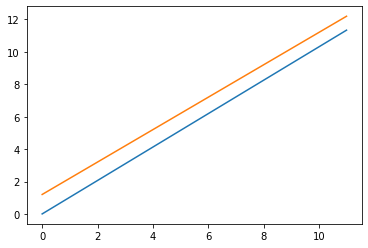

In [5]:
plt.plot(np.arange(0,12), np.arange(0,12)+np.arange(0,12)*0.031)
plt.plot(np.arange(0,12), np.arange(0,12)+1.2)

Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [6]:
cmip_tcw_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc', concat_dim='model', combine='nested').load()
#cmip_tcw_map = uda.shift_lons(cmip_tcw_map)

In [7]:
cmip_tcw_map

<xarray.Dataset>
Dimensions:       (lat: 25, lon: 21, model: 38)
Coordinates:
  * lat           (lat) float64 0.0 1.25 2.5 3.75 5.0 ... 26.25 27.5 28.75 30.0
  * lon           (lon) float64 -18.75 -16.88 -15.0 -13.12 ... 15.0 16.88 18.75
    month_number  int64 8
    time          (model) object 161632800000000000 ... 1975-02-14 18:00:00
    year          int64 1974
Dimensions without coordinates: model
Data variables:
    prw           (model, lat, lon) float64 12.96 12.86 12.73 ... nan nan nan

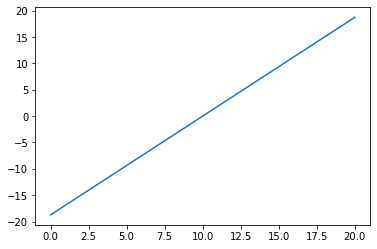

In [8]:
plt.plot(cmip_tcw_map.lon)

In [9]:
cmip_sh_map = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua*.nc', concat_dim='model', combine='nested').load()
#cmip_sh_map = uda.shift_lons(cmip_sh_map)

In [10]:
cmip_sh_map

<xarray.Dataset>
Dimensions:       (lat: 25, lon: 21, model: 38)
Coordinates:
  * lat           (lat) float64 0.0 1.25 2.5 3.75 5.0 ... 26.25 27.5 28.75 30.0
  * lon           (lon) float64 -18.75 -16.88 -15.0 -13.12 ... 15.0 16.88 18.75
    month_number  int64 8
    time          (model) object 1975-02-16 00:00:00 ... 1975-02-14 18:00:00
    year          int64 1974
Dimensions without coordinates: model
Data variables:
    unknown       (model, lat, lon) float64 3.575 3.608 3.592 ... nan nan nan

In [11]:
cmip_sh_wa = cmip_sh_map['unknown'].sel(lon=slice(-18,25), lat=slice(0,25)).load()*shearfac

In [12]:
cmip_tcw_wa = cmip_tcw_map['prw'].sel(lon=slice(-18,25), lat=slice(0,25)).load()*tcabsfac

In [13]:
cmip_both = cmip_tcw_wa + cmip_sh_wa

In [14]:
cmip_tcw_wa

<xarray.DataArray 'prw' (model: 38, lat: 21, lon: 20)>
array([[[15.68541762, 15.53272163, 15.42273457, ..., 17.70389105,
         18.21870152, 18.60543685],
        [17.67971223, 17.41990272, 17.21122937, ..., 18.16369216,
         18.67106461, 18.83194479],
        [19.53167744, 19.30583066, 19.10783446, ..., 18.1953151 ,
         18.82955453, 19.08526424],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[16.25577874, 16.0289715 , 15.82466395, ..., 17.69810477,
         18.34094601, 18.61264982],
        [18.27388007, 18.08607122, 17.90371015, ..., 18.33535084,
         19.0861641 , 19.40462058],
        [19.89136267, 19.80685288, 19.67190564, ..., 18.61673132,
         19.42517409, 19.87130733],
...
        [ 9.47189526,  9.35224268,  9.46825656, ...,         nan,
                 nan,         nan],
        [ 9.29995891,  9.12325368,  9.21400763, ...,         nan,
                 nan,         nan],
        [ 9.25864079,  8.93693481,  8.84311123, ...,         nan,
                 nan,         nan]],

       [[11.50959683, 11.50671167, 11.48228092, ..., 12.44051589,
         13.06425662, 13.70709118],
        [12.56414706, 12.6357332 , 12.6172748 , ..., 13.04656114,
         13.67326592, 14.32090125],
        [12.95652267, 13.05602907, 13.0369141 , ..., 13.09531966,
         13.6910636 , 14.30228328],
        ...,
        [ 6.77774936,  6.45543194,  6.03150824, ...,         nan,
                 nan,         nan],
        [ 6.25464714,  5.97853808,  5.61590812, ...,         nan,
                 nan,         nan],
        [ 6.08575368,  5.89747234,  5.64023528, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat           (lat) float64 0.0 1.25 2.5 3.75 5.0 ... 21.25 22.5 23.75 25.0
  * lon           (lon) float64 -16.88 -15.0 -13.12 -11.25 ... 15.0 16.88 18.75
    month_number  int64 8
    time          (model) object 161632800000000000 ... 1975-02-14 18:00:00
    year          int64 1974
Dimensions without coordinates: model

In [15]:
def draw_map(ax, dat, lat, lon, title='', levels=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap='jet', extend='both', levels=levels)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(r'mm h$^{-1}$')

In [16]:
model_names = []
for mods in glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_*.nc'):
    tcw_map = xr.open_dataset(mods)
    model_names.append(tcw_map['prw'].attrs['model_id'])

In [17]:
model_names

['NorESM1-M',
 'FGOALS-g2',
 'HadGEM2-ES',
 'bcc-csm1-1',
 'CCSM4',
 'CNRM-CM5',
 'CSIRO-Mk3-6-0',
 'GISS-E2-H',
 'GISS-E2-R',
 'IPSL-CM5B-LR',
 'MIROC-ESM-CHEM',
 'MIROC-ESM',
 'MIROC5',
 'MPI-ESM-MR',
 'MRI-CGCM3',
 'MRI-ESM1',
 'CESM1-CAM5',
 'CMCC-CESM',
 'CMCC-CMS',
 'CMCC-CM',
 'FIO-ESM',
 'GFDL-CM3',
 'GFDL-ESM2G',
 'GFDL-ESM2M',
 'GISS-E2-H-CC',
 'GISS-E2-R-CC',
 'HadGEM2-CC',
 'inmcm4',
 'CESM1-BGC',
 'IPSL-CM5A-MR',
 'NorESM1-ME',
 'IPSL-CM5A-LR',
 'MPI-ESM-LR',
 'ACCESS1-0',
 'ACCESS1-3',
 'bcc-csm1-1-m',
 'BNU-ESM',
 'CanESM2']

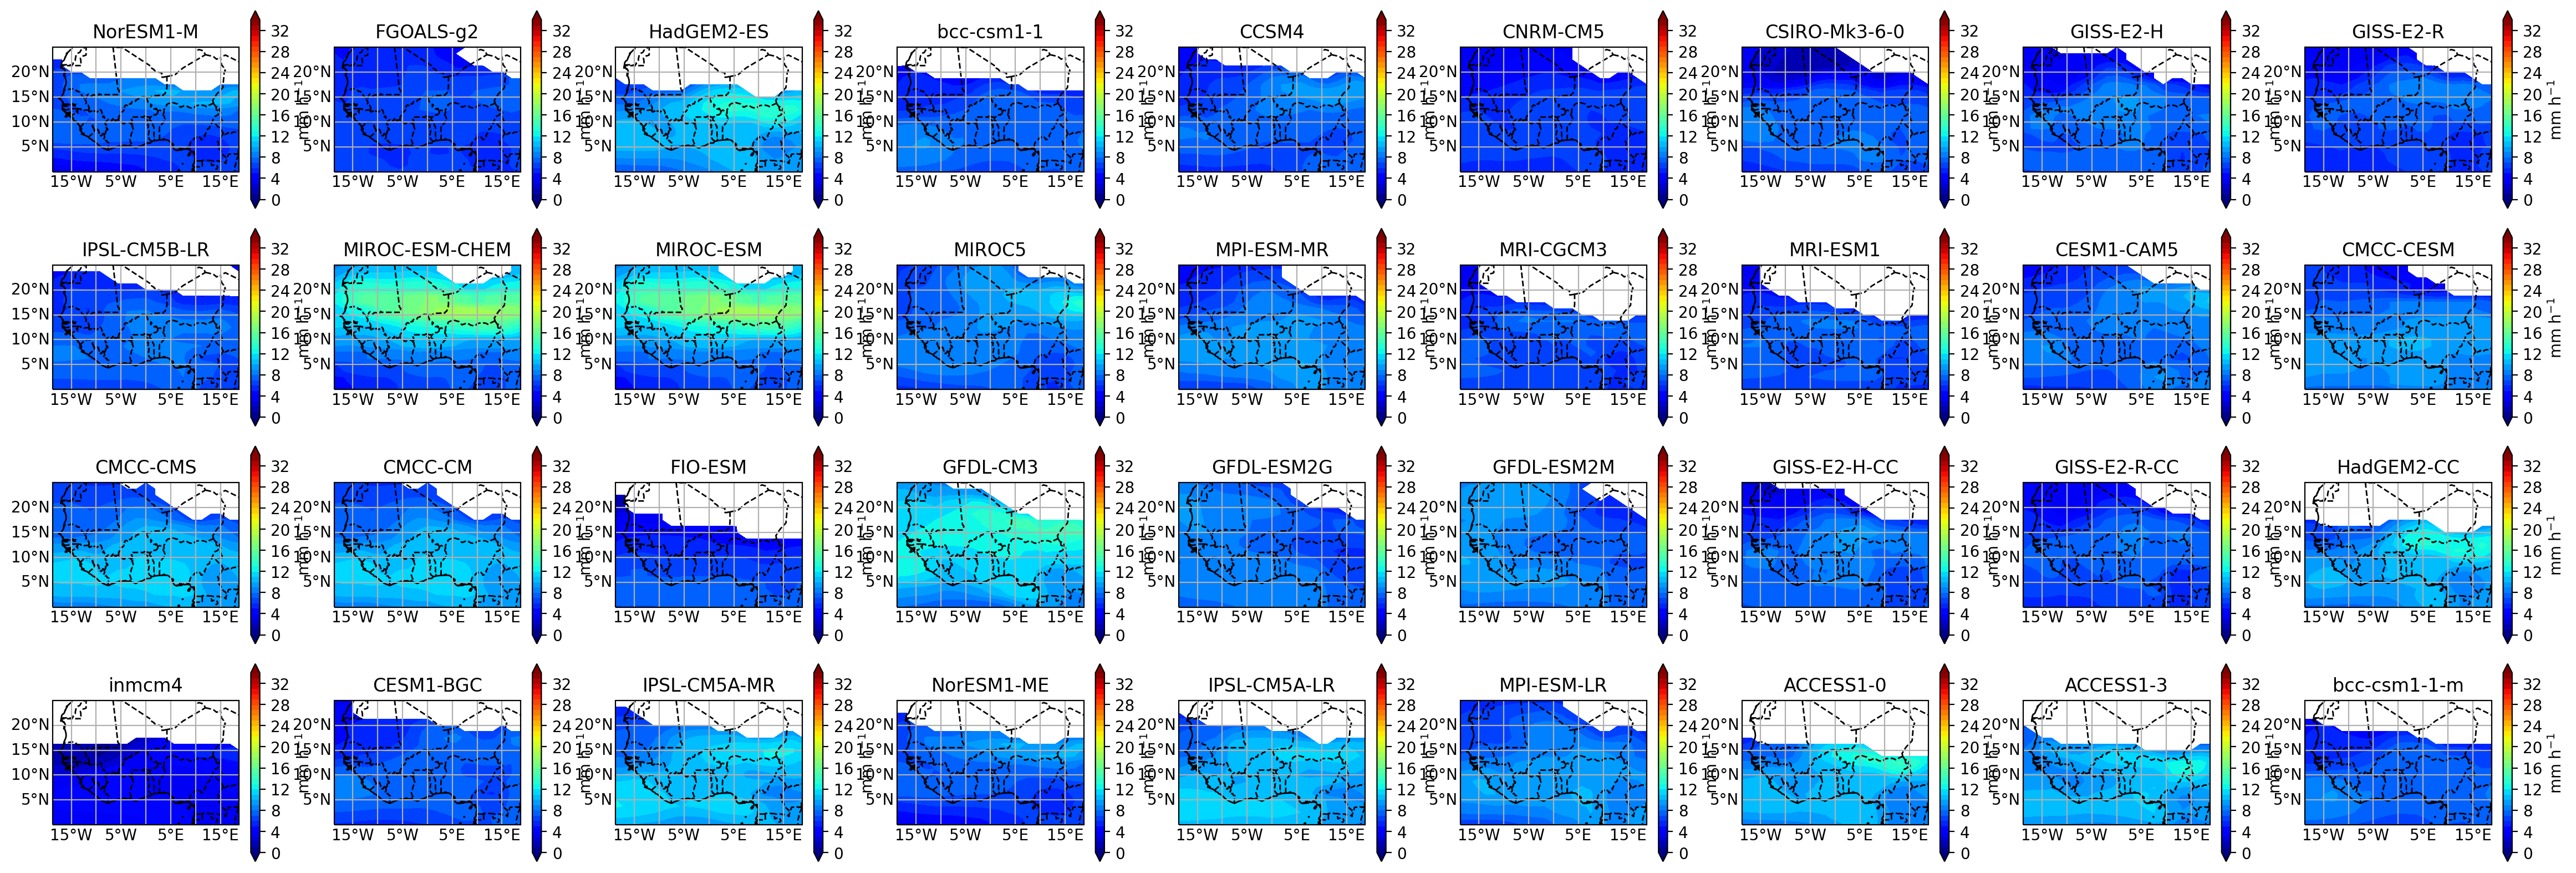

In [18]:
f = plt.figure(figsize=(23,8), dpi=200)

for num, model in enumerate(model_names[0:36]):
 
    file = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2040/prw_2006*_'+model+'*.nc')
    tcw_map = xr.open_dataset(file[0])

    cmip_tcw_wa = tcw_map['prw']
    cmip_tcw_wa = cmip_tcw_wa.sel(lon=slice(-20,20), lat=slice(0,25))*tcabsfac
    
    posi = num+1
    
    ax = f.add_subplot(4,9,posi, projection=ccrs.PlateCarree())
    ax.set_ylim(0,25)
    draw_map(ax, cmip_tcw_wa, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model, levels=np.arange(0,35))   #[num,:,:]

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/TCW_precip.png')

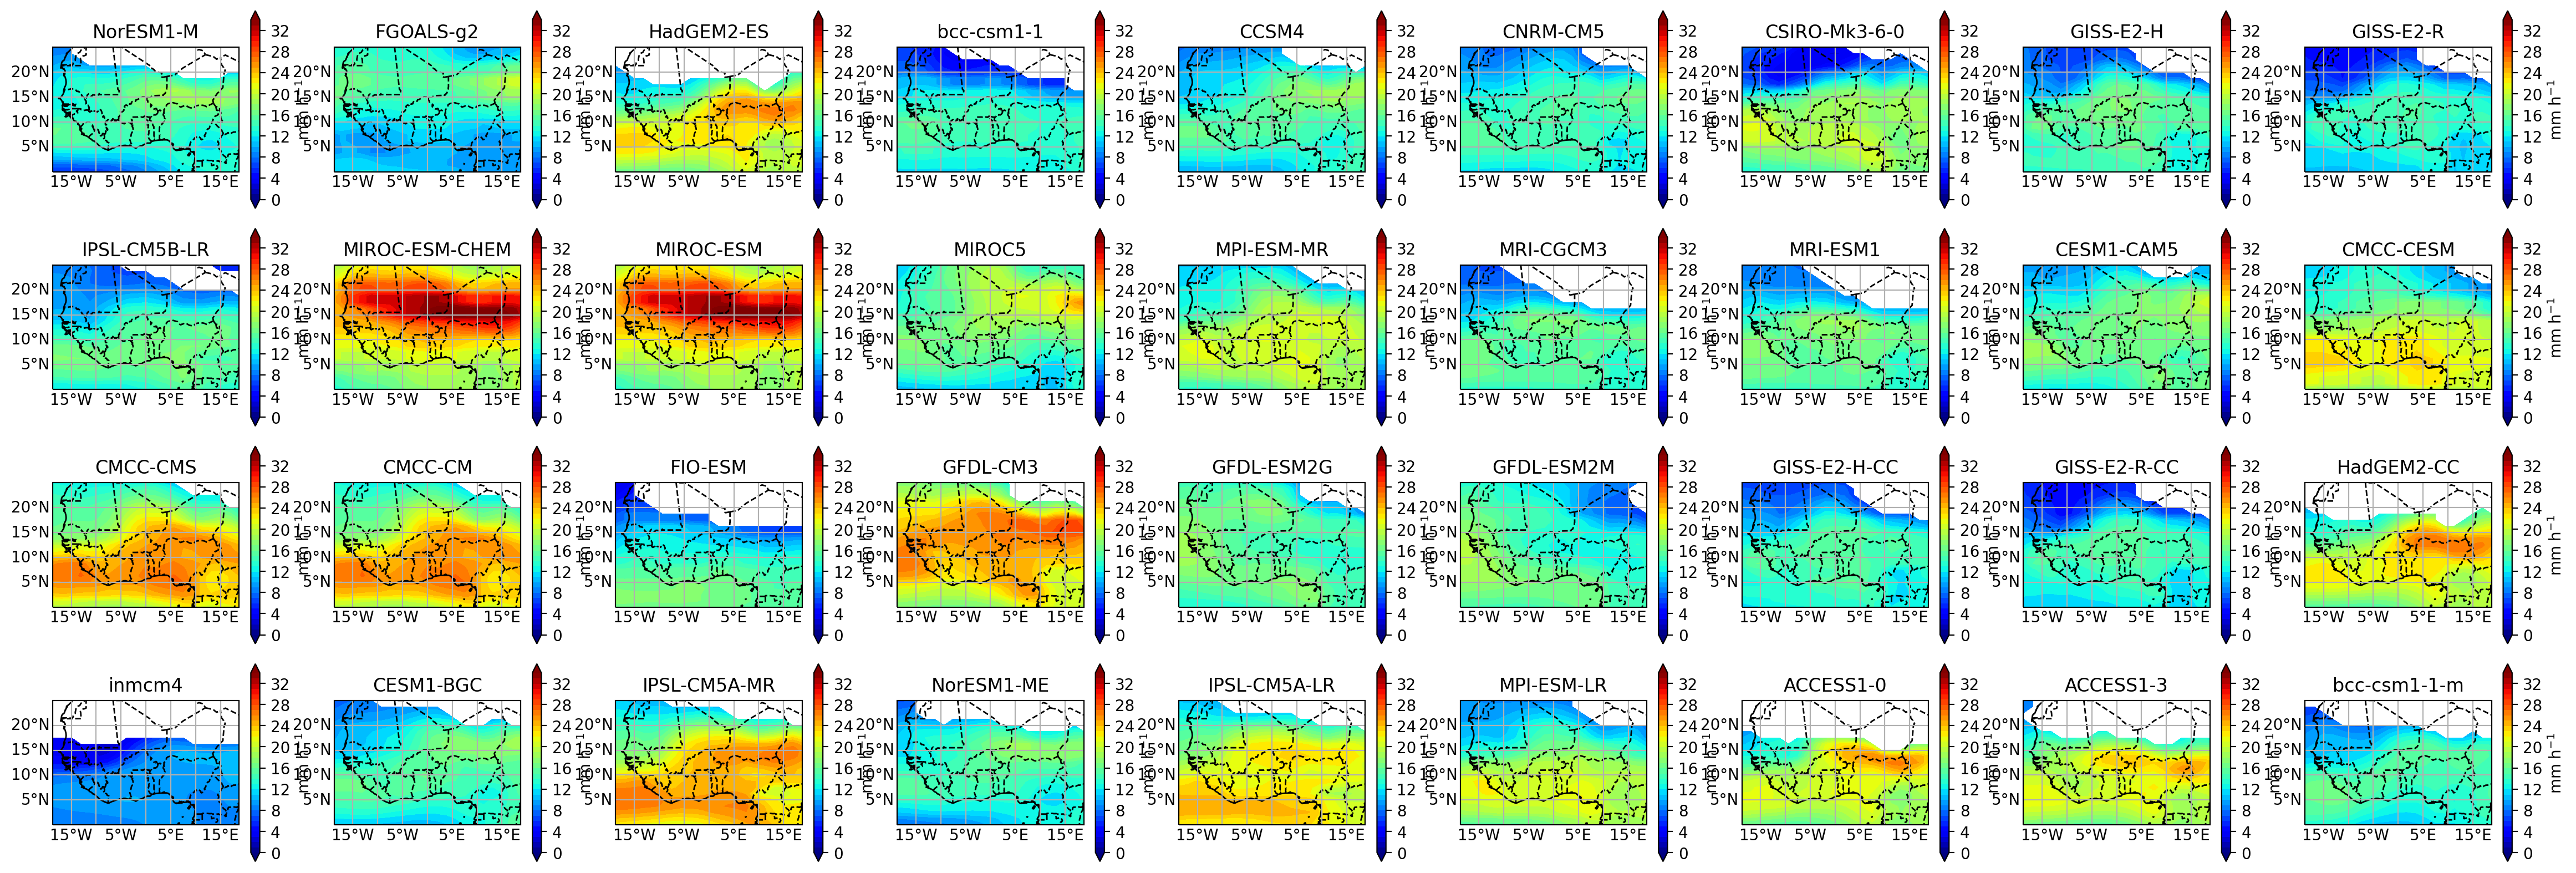

In [19]:
f = plt.figure(figsize=(23,8), dpi=200)

for num, model in enumerate(model_names[0:36]):
 
    file = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_2006*_'+model+'*.nc')
    tcw_map = xr.open_dataset(file[0])

    cmip_tcw_wa = tcw_map['prw']
    cmip_tcw_wa = cmip_tcw_wa.sel(lon=slice(-20,20), lat=slice(0,25))*tcabsfac
    
    posi = num+1
    
    ax = f.add_subplot(4,9,posi, projection=ccrs.PlateCarree())
    ax.set_ylim(0,25)
    draw_map(ax, cmip_tcw_wa, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model, levels=np.arange(0,35))   #[num,:,:]

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/TCW_precip.png')

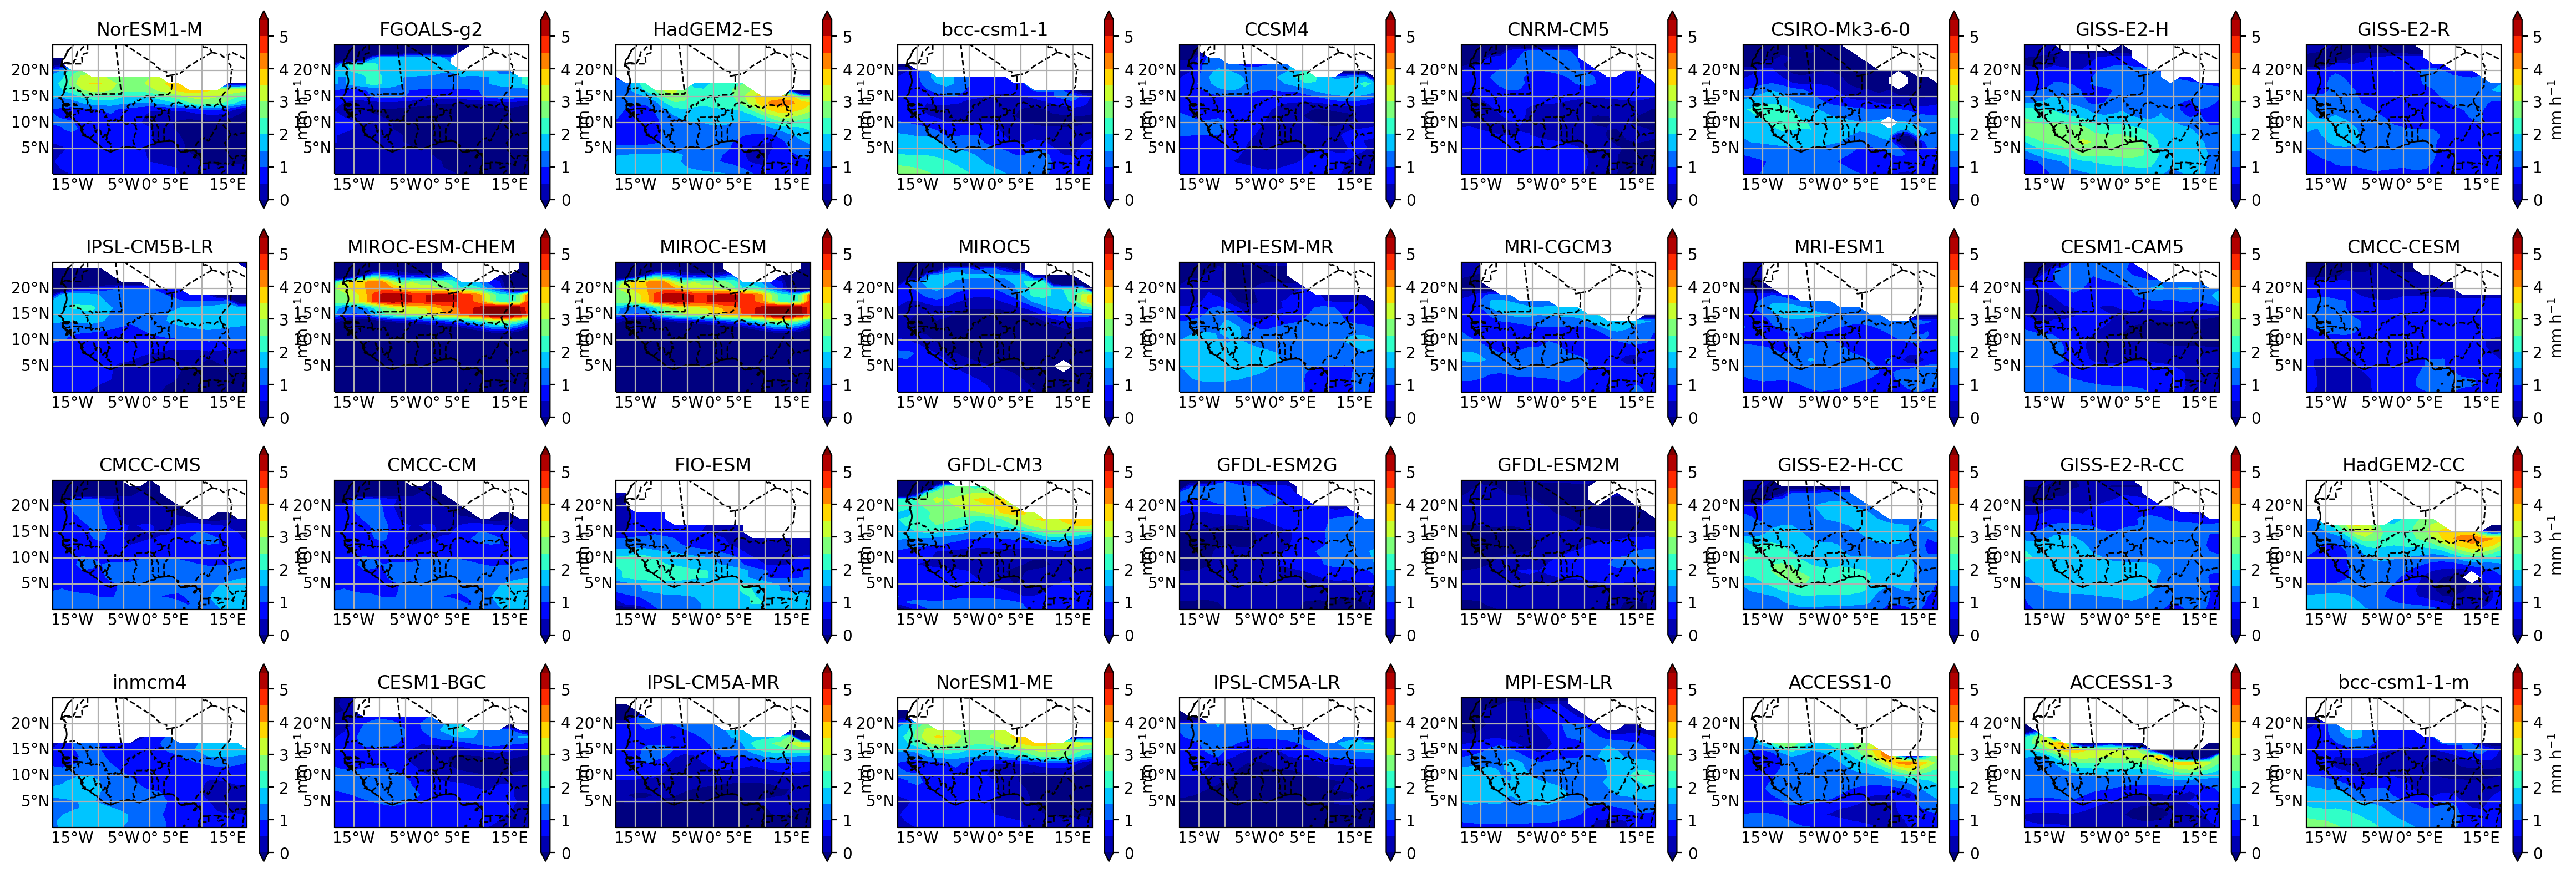

In [20]:
f = plt.figure(figsize=(23,8), dpi=200)

for num, model in enumerate(model_names[0:36]):
#for num in range(36):   
    file = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2040/ua*_'+model+'*.nc')
    tcw_map = xr.open_dataset(file[0])


    cmip_tcw_wa = tcw_map['unknown']

    cmip_tcw_wa = cmip_tcw_wa.sel(lon=slice(-20,20), lat=slice(0,25))#*shearfac
    
    posi = num+1

    
    ax = f.add_subplot(4,9,posi, projection=ccrs.PlateCarree())
    
    ax.set_ylim(0,25)

    draw_map(ax, cmip_tcw_wa, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model, levels=np.arange(0,6,0.5))   #[num,:,:]
    

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/shear_precip.png') 

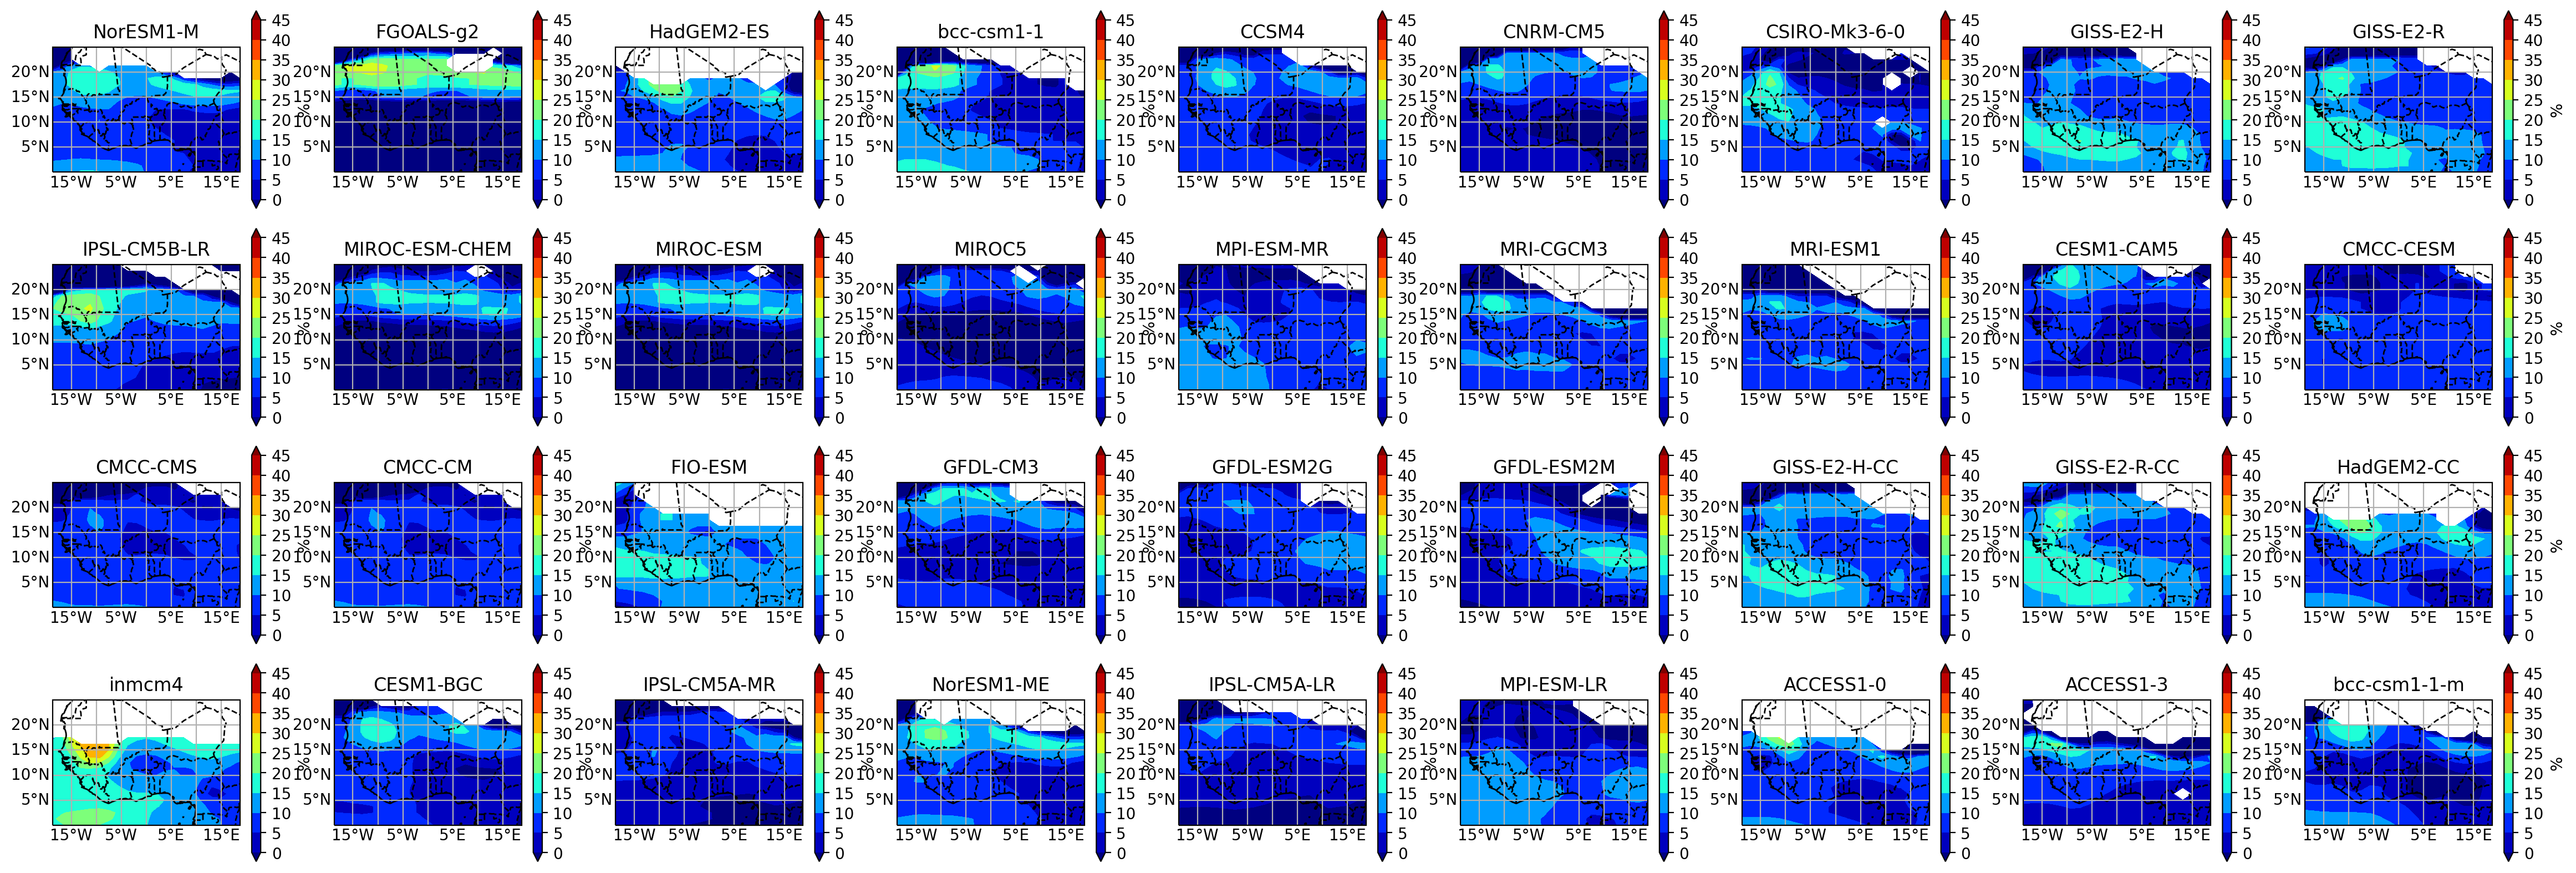

In [21]:
def draw_map(ax, dat, lat, lon, title='', levels=None):
   
    plt.contourf(lon, lat, dat, transform=ccrs.PlateCarree(), cmap='jet', extend='both', levels=levels)
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(r'%')

f = plt.figure(figsize=(23,8), dpi=200)

for num, model in enumerate(model_names[0:36]):
  
    file = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/tcw_diff_2080/prw_2006*_'+model+'*.nc')
    tcw_map = xr.open_dataset(file[0])
    shfile = glob.glob('/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/shear_diff_2080/ua*_'+model+'*.nc')
    sh_map = xr.open_dataset(shfile[0])

    cmip_tcw_wa = tcw_map['prw']
    cmip_sh_wa = sh_map['unknown']

    cmip_tcw_wa = cmip_tcw_wa.sel(lon=slice(-20,20), lat=slice(0,25))*tcabsfac
    cmip_sh_wa = cmip_sh_wa.sel(lon=slice(-20,20), lat=slice(0,25))*shearfac
    
    both = cmip_sh_wa / (cmip_tcw_wa+cmip_sh_wa) *100
    posi = num+1
       
    ax = f.add_subplot(4,9,posi, projection=ccrs.PlateCarree())
    ax.set_ylim(0,25)
    
    draw_map(ax, both, cmip_tcw_wa.lat, cmip_tcw_wa.lon, title=model, levels=np.arange(0,50,5))   #[num,:,:]

plt.tight_layout()
#f.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/shearContribution_shear+tcw.png')